# RL CartPole: Actor Critic

In [1]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam


Observation space: (4,) n_actions: 2


c:\Users\pierg\Desktop\VirtualEnvironments\Standard_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1: Reward = 32.0, Mean reward = 32.0
Episode 2: Reward = 52.0, Mean reward = 32.0
Episode 3: Reward = 25.0, Mean reward = 42.0
Episode 4: Reward = 24.0, Mean reward = 36.333333333333336
Episode 5: Reward = 21.0, Mean reward = 33.25
Episode 6: Reward = 24.0, Mean reward = 30.8
Episode 7: Reward = 22.0, Mean reward = 29.666666666666668
Episode 8: Reward = 50.0, Mean reward = 28.571428571428573
Episode 9: Reward = 25.0, Mean reward = 31.25
Episode 10: Reward = 9.0, Mean reward = 30.555555555555557
Episode 11: Reward = 22.0, Mean reward = 28.4
Episode 12: Reward = 30.0, Mean reward = 27.818181818181817
Episode 13: Reward = 33.0, Mean reward = 28.0
Episode 14: Reward = 12.0, Mean reward = 28.384615384615383
Episode 15: Reward = 10.0, Mean reward = 27.214285714285715
Episode 16: Reward = 38.0, Mean reward = 26.066666666666666
Episode 17: Reward = 23.0, Mean reward = 26.8125
Episode 18: Reward = 35.0, Mean reward = 26.58823529411765
Episode 19: Reward = 26.0, Mean reward = 27.05555555

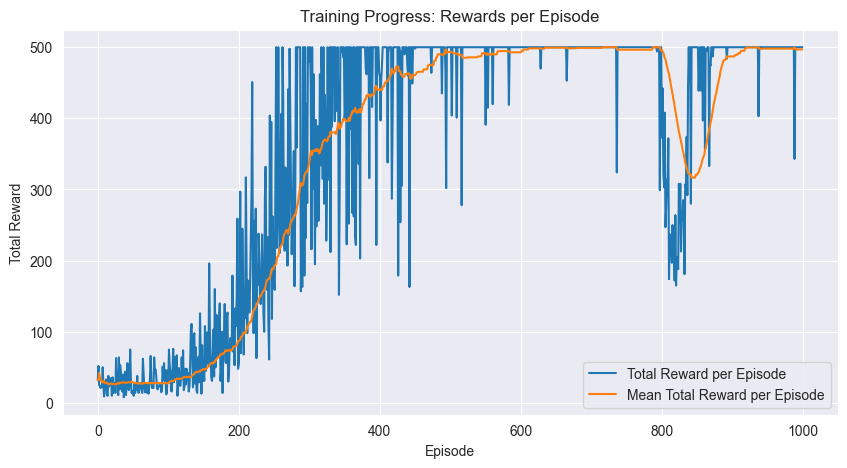

In [4]:
from collections import deque
import time

#---------- Environment and seeds -----------------#

env = gym.make('CartPole-v1')
input_shape = env.observation_space.shape
n_actions = env.action_space.n
print("Observation space:", input_shape, "n_actions:", n_actions)

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
env.action_space.seed(42)  # Ensures deterministic action sampling



#---------- Parameters -----------------#

n_iterations = 1000
gamma = 0.99  # Discount factor
learning_rate_actor = 0.001
learning_rate_critic = 0.001
batch_size = 32
tau = 0.01


#---------- Neural nets-----------------#

actor_model = Sequential([
    Dense(32, activation='relu', input_shape=input_shape),
    Dense(32, activation='relu'),
    Dense(n_actions, activation='softmax')                         
])

critic_model = Sequential([
    Dense(32, activation='relu', input_shape=input_shape),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')                       # Single value for teh critic (V-value) which is V(s)            
])

inital_weights_actor = actor_model.get_weights()
inital_weights_critic = critic_model.get_weights()

# Optimizer and loss
optimizer_actor = Adam(learning_rate=learning_rate_actor)
optimizer_critic = Adam(learning_rate=learning_rate_critic)

def actor_loss(advantages, actions, actor_model):
    log_probs = tf.math.log(actor_model)  # Log of the predicted probabilities
    action_log_prob = tf.reduce_sum(log_probs * actions, axis=1)
    return -tf.reduce_mean(action_log_prob * advantages)  # Policy gradient loss (negative for maximization)

def critic_loss(critic_values, rewards, values_next, discount_factor=0.99):
    # TD Error as loss
    td_target = rewards + discount_factor * values_next
    return tf.reduce_mean(tf.square(td_target - critic_values))  # MSE loss for critic




#---------- Neural fast functions-----------------#

@tf.function  
def predict_actorModel_fast(state):
    return actor_model(state, training=False)  

@tf.function  
def predict_criticModel_fast(state):
    return critic_model(state, training=False)  


#---------- Play Episodes functions -----------------#



# Function to take a step and store transition
def actor_critic_step(state):
    #state = np.expand_dims(state, axis=0)
    #action_probs = actor_model(state)
    action_probs = predict_actorModel_fast(state[np.newaxis])
    action = np.random.choice(n_actions, p=action_probs.numpy()[0])  # Sample action
    return action

# Select action using the policy
def choose_action(state, actor_model):
    #state = np.expand_dims(state, axis=0)
    #probs = actor_model.predict(state, verbose=0)[0]
    probs = predict_actorModel_fast(state[np.newaxis])
    action = np.random.choice(n_actions, p=probs.numpy()[0])
    return action


#---------- Normalization and discount of the rewards -----------------#

def compute_returns(rewards, dones, next_state, critic_model):
    returns = []
    #R = critic_model.predict(np.expand_dims(next_state, axis=0), verbose=0)[0, 0]
    R = predict_criticModel_fast(next_state[np.newaxis])[0, 0]
    for reward, done in zip(reversed(rewards), reversed(dones)):
        R = reward + (1 - done) * gamma * R
        returns.insert(0, R)
    return np.array(returns)



#---------- Gradient related functions (training) -----------------#

def train(actor_model, critic_model, optimizer_actor, optimizer_critic, states, actions, returns):
    with tf.GradientTape() as tape_actor, tf.GradientTape() as tape_critic:
        states = np.array(states)
        actions = np.array(actions)
        
        # Compute values and advantages
        values = critic_model(states)
        advantages = returns - tf.squeeze(values)

        # Actor loss (policy gradient)
        action_probs = actor_model(states)
        action_masks = tf.one_hot(actions, n_actions)
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs + 1e-8), axis=1)
        actor_loss = -tf.reduce_mean(log_probs * advantages)

        # Critic loss (MSE)
        critic_loss = tf.reduce_mean(tf.square(returns - values))

    # Compute gradients and update models
    actor_grads = tape_actor.gradient(actor_loss, actor_model.trainable_variables)
    critic_grads = tape_critic.gradient(critic_loss, critic_model.trainable_variables)
    optimizer_actor.apply_gradients(zip(actor_grads, actor_model.trainable_variables))
    optimizer_critic.apply_gradients(zip(critic_grads, critic_model.trainable_variables))

    

def soft_update_weights(model, tau=tau):
    # Perform a soft update on the weights
    current_weights = model.get_weights()
    updated_weights = model.get_weights()  # Get new weights after applying gradients

    # Soft update rule
    new_weights = [tau * updated + (1 - tau) * current for updated, current in zip(updated_weights, current_weights)]
    
    model.set_weights(new_weights)  # Update the model with blended weights



    




#---------- Training -----------------#

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

total_rewards_list = []
mean_rewards_list = []
best_score = 0
total_rewards = 0

actor_model.set_weights(inital_weights_actor)
critic_model.set_weights(inital_weights_critic)


for episode in range(n_iterations):
    state = env.reset()
    done = False
    total_reward = 0
    states, actions, rewards, dones = [], [], [], []

    while not done:
        action = choose_action(state, actor_model)
        next_state, reward, done, _ = env.step(action)

        # Store experience
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)

        state = next_state
        total_reward += reward

    # Compute returns and train models
    total_rewards += total_reward
    m_r = np.mean(total_rewards_list[-50:]) if total_rewards_list else total_reward
    mean_rewards_list.append(m_r)
    total_rewards_list.append(total_reward)

    if mean_rewards_list[-1] > best_score:
        best_weights_actor = actor_model.get_weights()
        best_weights_critic = critic_model.get_weights()
        best_score = mean_rewards_list[-1]

    returns = compute_returns(rewards, dones, next_state, critic_model)
    train(actor_model, critic_model, optimizer_actor, optimizer_critic, states, actions, returns)

    print(f"Episode {episode + 1}: Reward = {total_reward}, Mean reward = {m_r}")

env.close()

actor_model.set_weights(best_weights_actor)
critic_model.set_weights(best_weights_critic)

# Use Seaborn to plot rewards per episode
sns.set_style("darkgrid")  # Set a nice style
plt.figure(figsize=(10, 5))  # Set figure size

sns.lineplot(x=range(len(total_rewards_list)), y=total_rewards_list, label="Total Reward per Episode")
sns.lineplot(x=range(len(mean_rewards_list)), y=mean_rewards_list, label="Mean Total Reward per Episode")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress: Rewards per Episode")
plt.legend()
plt.show()



In [6]:
# For plotting the animated video
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


state = env.reset()
random.seed(None)  # Reset to default, random state
np.random.seed(None)
tf.random.set_seed(None)


frames = []
total_reward = 0
average_reward = 0
total_rewards = 0
n_max_steps = 1000
# Interact with the environment using the trained model
for i in range(30):
    total_reward = 0
    obs = env.reset()
    for step in range(n_max_steps):
        # Get action probabilities from the model
        action = choose_action(state=obs, actor_model=actor_model)
        obs, reward, done, info = env.step(action)
        total_reward += reward
    
        if done:
            break
        frames.append(env.render(mode="rgb_array"))  # Collect frames for animation
    total_rewards += total_reward
    average_reward = total_rewards / (i+ 1)
    print(f"Episode: {i+1}, Total Reward:{total_reward}, Mean Reward: {average_reward}")
    #plot_animation(frames)

# Close the environment
#env.close()





Episode: 1, Total Reward:500.0, Mean Reward: 500.0
Episode: 2, Total Reward:500.0, Mean Reward: 500.0
Episode: 3, Total Reward:500.0, Mean Reward: 500.0
Episode: 4, Total Reward:500.0, Mean Reward: 500.0
Episode: 5, Total Reward:500.0, Mean Reward: 500.0
Episode: 6, Total Reward:500.0, Mean Reward: 500.0
Episode: 7, Total Reward:500.0, Mean Reward: 500.0
Episode: 8, Total Reward:500.0, Mean Reward: 500.0
Episode: 9, Total Reward:500.0, Mean Reward: 500.0
Episode: 10, Total Reward:500.0, Mean Reward: 500.0
Episode: 11, Total Reward:500.0, Mean Reward: 500.0
Episode: 12, Total Reward:500.0, Mean Reward: 500.0
Episode: 13, Total Reward:500.0, Mean Reward: 500.0
Episode: 14, Total Reward:500.0, Mean Reward: 500.0
Episode: 15, Total Reward:500.0, Mean Reward: 500.0
Episode: 16, Total Reward:500.0, Mean Reward: 500.0
Episode: 17, Total Reward:500.0, Mean Reward: 500.0
Episode: 18, Total Reward:500.0, Mean Reward: 500.0
Episode: 19, Total Reward:500.0, Mean Reward: 500.0
Episode: 20, Total Re